#### Chapter 29
### Analyzing Neural Time Series Data
Python code for Chapter 29 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr, rankdata
from scipy.io import loadmat
from scipy.fftpack import fft, ifft
from mne import create_info, EvokedArray
from mne.channels import make_dig_montage
from mutualinformationx import mutualinformationx

### Figure 29.2

Entropies of sine wave and random noise are 5.371662108209934 and 5.640736620183756.


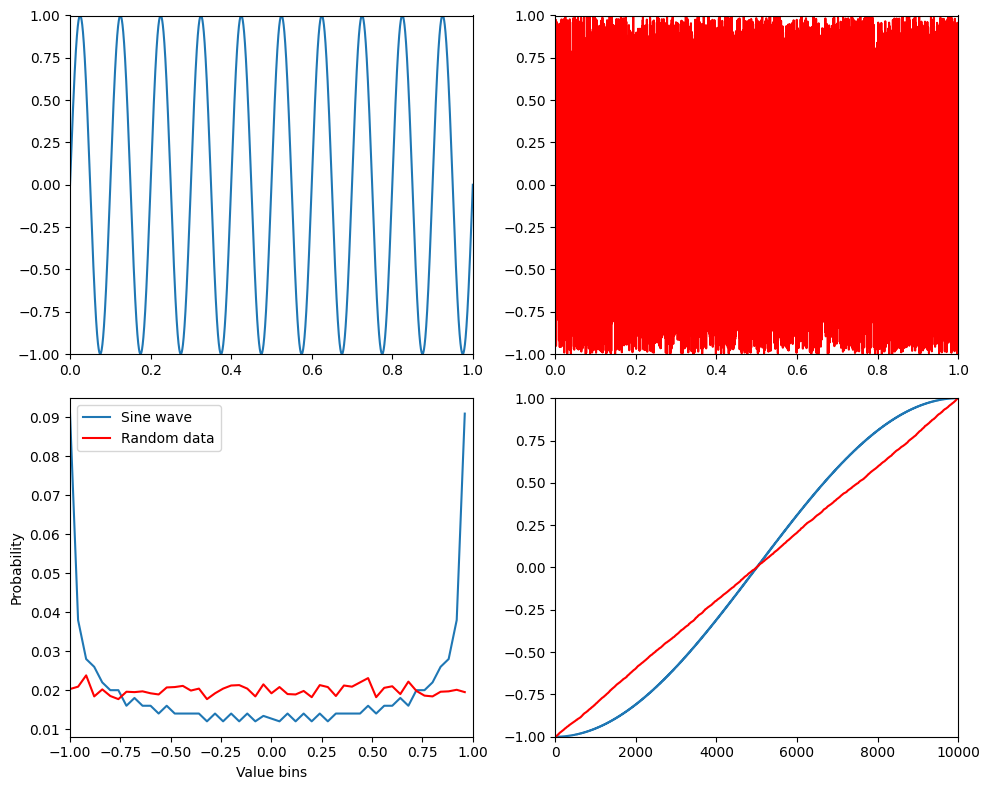

In [2]:
# create two signals
time = np.arange(0, 1.0001, 0.0001)
signal1 = np.sin(2 * np.pi * 10 * time)
signal2 = np.random.rand(len(signal1)) * 2 - 1  # uniform random numbers in the same scale as the sine wave

# plot signals
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.plot(time, signal1)
plt.xlim([time[0], time[-1]])
plt.ylim([-1, 1])

plt.subplot(222)
plt.plot(time, signal2, 'r')
plt.xlim([time[0], time[-1]])
plt.ylim([-1, 1])

# bin data
nbins = 50
hdat1, x1 = np.histogram(signal1, bins=nbins)
hdat2, x2 = np.histogram(signal2, bins=nbins)

# convert to probability
hdat1 = hdat1 / np.sum(hdat1)
hdat2 = hdat2 / np.sum(hdat2)

# plot histograms
plt.subplot(223)
plt.plot(x1[:-1], hdat1, label='Sine wave')
plt.plot(x2[:-1], hdat2, 'r', label='Random data')
plt.legend()
plt.xlim([-1, 1])
plt.xlabel('Value bins')
plt.ylabel('Probability')

plt.subplot(224)
plt.plot(np.sort(signal1))
plt.plot(np.sort(signal2), 'r')
plt.xlim([0, len(signal1)])
plt.ylim([-1, 1])

# compute entropy
entro = np.zeros(2)
entro[0] = -np.sum(hdat1 * np.log2(hdat1 + np.finfo(float).eps))
entro[1] = -np.sum(hdat2 * np.log2(hdat2 + np.finfo(float).eps))

print(f'Entropies of sine wave and random noise are {entro[0]} and {entro[1]}.')

plt.tight_layout()
plt.show()

### Figure 29.3

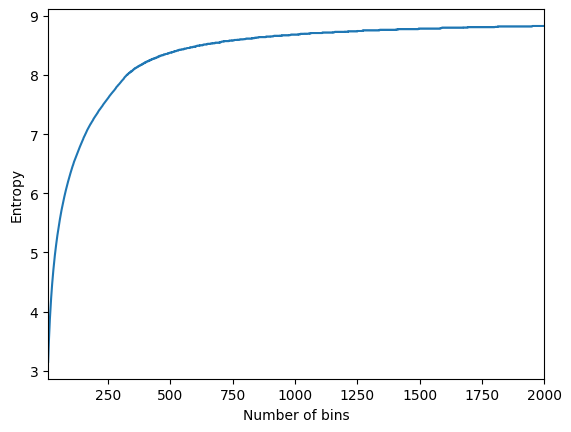

In [3]:
# range of bin numbers
nbins = np.arange(10, 2001)

entropyByBinSize = np.zeros(len(nbins))

for nbini in range(len(nbins)):
    # bin data, transform to probability, and eliminate zeros
    hdat, _ = np.histogram(signal1, bins=nbins[nbini])
    hdat = hdat / np.sum(hdat)
    
    # compute entropy
    entropyByBinSize[nbini] = -np.sum(hdat * np.log2(hdat + np.finfo(float).eps))

plt.figure()
plt.plot(nbins, entropyByBinSize)
plt.xlim([nbins[0], nbins[-1]])
plt.xlabel('Number of bins')
plt.ylabel('Entropy')
plt.show()

### Figure 29.4

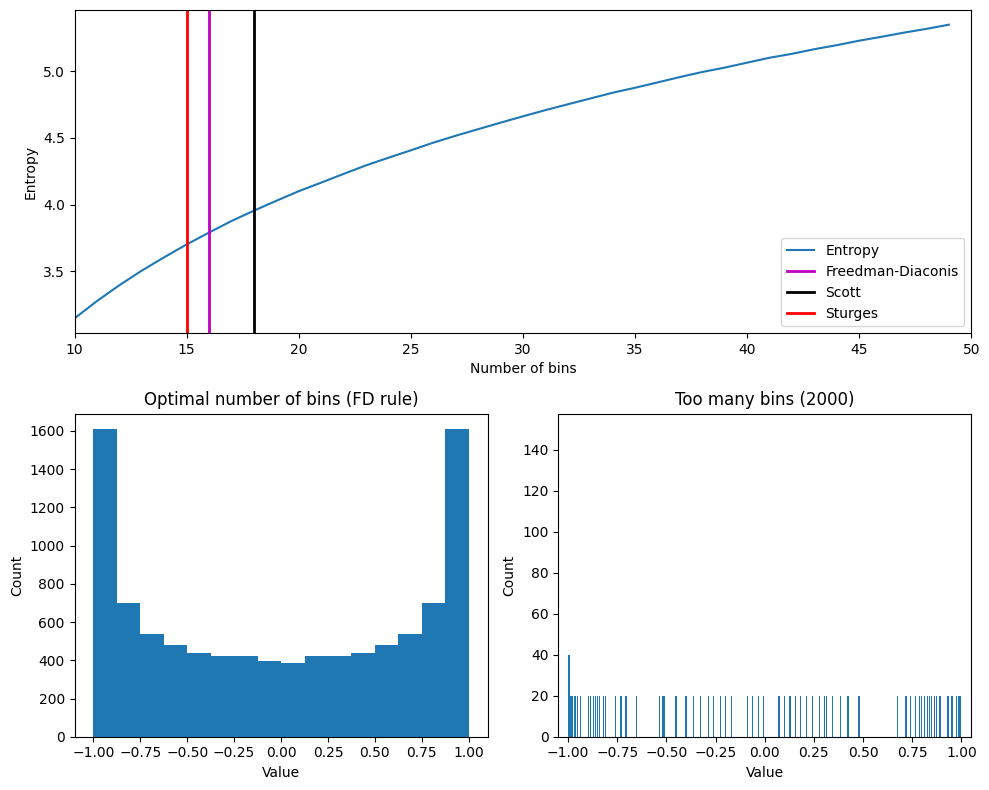

In [4]:
# optimal number of bins for histogram based on a few different guidelines
n = len(signal1)
maxmin_range = np.max(signal1) - np.min(signal1)

# Freedman-Diaconis, Scott, and Sturges rules for bin width
fd_bins = np.ceil(maxmin_range / (2.0 * iqr(signal1) * n ** (-1/3)))
scott_bins = np.ceil(maxmin_range / (3.5 * np.std(signal1) * n ** (-1/3)))
sturges_bins = np.ceil(1 + np.log2(n))

plt.figure(figsize=(10, 8))

plt.subplot(211)
# plot up to 50 bins
maxNbins = np.argmin(np.abs(nbins - 50))  # index of nbins that most closely matches 50
plt.plot(nbins[:maxNbins], entropyByBinSize[:maxNbins], label='Entropy')

plt.axvline(fd_bins, color='m', linewidth=2, label='Freedman-Diaconis')
plt.axvline(scott_bins, color='k', linewidth=2, label='Scott')
plt.axvline(sturges_bins, color='r', linewidth=2, label='Sturges')

plt.legend()
plt.xlim([nbins[0], nbins[maxNbins]])
plt.xlabel('Number of bins')
plt.ylabel('Entropy')

plt.subplot(223)
y, x = np.histogram(signal1, bins=int(fd_bins))
plt.bar(x[:-1], y, width=np.diff(x), align='edge', edgecolor='none')
plt.xlim([np.min(signal1) * 1.1, np.max(signal1) * 1.1])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Optimal number of bins (FD rule)')

plt.subplot(224)
y, x = np.histogram(signal1, bins=2000)
plt.bar(x[:-1], y, width=np.diff(x), align='edge', edgecolor='none')
plt.xlim([np.min(signal1) * 1.05, np.max(signal1) * 1.05])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Too many bins (2000)')

plt.tight_layout()
plt.show()

### Figure 29.5

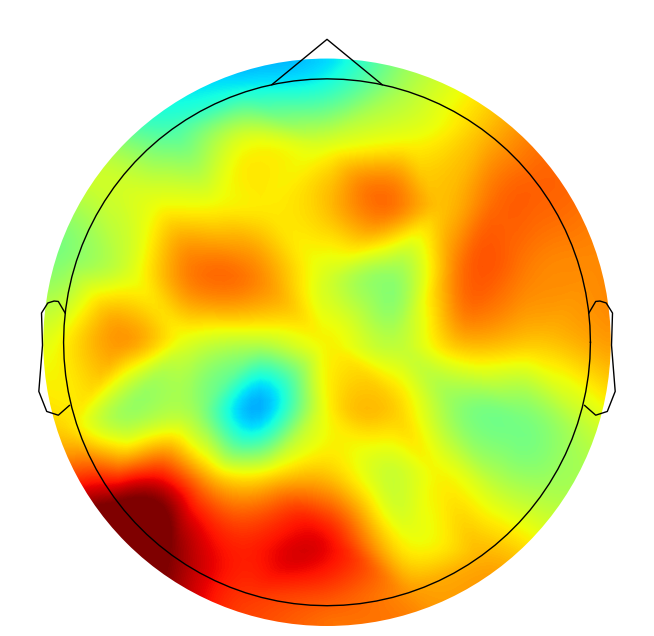

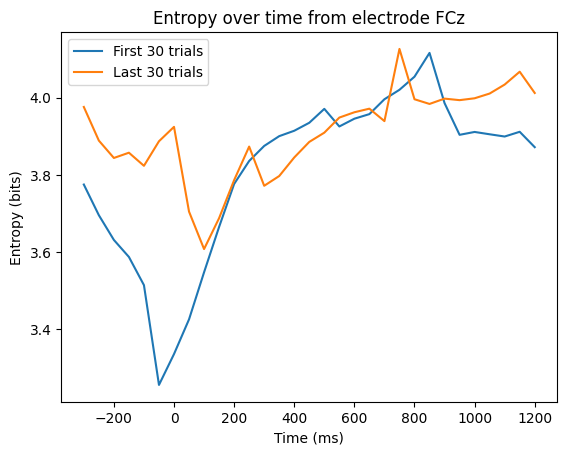

In [5]:
# Load sample EEG data
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Define time windows for entropy calculation
time4entropy = [100, 400]  # in ms
base4entropy = [-400, -100]  # in ms
topo_entropy = np.zeros(EEG['nbchan'][0][0])

# Convert time windows to indices
timeidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in time4entropy]
baseidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in base4entropy]

# Calculate entropy for each channel
for chani in range(EEG['nbchan'][0][0]):
    # Entropy during task
    tempdat = EEG['data'][chani, timeidx[0]:timeidx[1]+1, :].flatten('F')
    hdat, _ = np.histogram(tempdat, bins=25)
    hdat = hdat / np.sum(hdat)
    task_entropy = -np.sum(hdat * np.log2(hdat + np.finfo(float).eps))
    
    # Entropy during pre-stim baseline
    tempdat = EEG['data'][chani, baseidx[0]:baseidx[1]+1, :].flatten('F')
    hdat, _ = np.histogram(tempdat, bins=25)
    hdat = hdat / np.sum(hdat)
    base_entropy = -np.sum(hdat * np.log2(hdat + np.finfo(float).eps))
    
    # Compute difference in entropy
    topo_entropy[chani] = task_entropy - base_entropy

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
topo_entropy = np.delete(topo_entropy, exclude_chans)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot the topographic map of entropy differences
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(111)
evoked = EvokedArray(topo_entropy[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sensors=False, contours=0, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=ax1, show=False, times=-1, time_format='', colorbar=False)

# Define sensor for entropy over time and parameters
sensor4entropy = 'FCz'
times2save = np.arange(-300, 1250, 50)  # in ms
timewindow = 400  # ms

# Convert ms to indices
timewindowidx = round(timewindow / (1000 / EEG['srate'][0][0]) / 2)
times2saveidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save]

# Find the index of the selected sensor
electrodeidx = EEG['chanlocs'][0]['labels']==sensor4entropy

# Initialize array to store entropy values
timeEntropy = np.zeros((2, len(times2save)))

# Calculate entropy over time for the selected sensor
for timei, tidx in enumerate(times2saveidx):
    # Data for first 30 trials
    tempdata = EEG['data'][electrodeidx, tidx - timewindowidx:tidx + timewindowidx + 1, :30].flatten('F')
    hdat, _ = np.histogram(tempdata, bins=25)
    hdat = hdat / np.sum(hdat)
    timeEntropy[0, timei] = -np.sum(hdat * np.log2(hdat + np.finfo(float).eps))
    
    # Data for last 30 trials
    tempdata = EEG['data'][electrodeidx, tidx - timewindowidx:tidx + timewindowidx + 1, -30:].flatten('F')
    hdat, _ = np.histogram(tempdata, bins=25)
    hdat = hdat / np.sum(hdat)
    timeEntropy[1, timei] = -np.sum(hdat * np.log2(hdat + np.finfo(float).eps))

# Plot the entropy over time
plt.figure()
plt.plot(times2save, timeEntropy[0, :], label='First 30 trials')
plt.plot(times2save, timeEntropy[1, :], label='Last 30 trials')
plt.xlabel('Time (ms)')
plt.ylabel('Entropy (bits)')
plt.title(f'Entropy over time from electrode {sensor4entropy}')
plt.legend()
plt.show()

### Figure 29.6

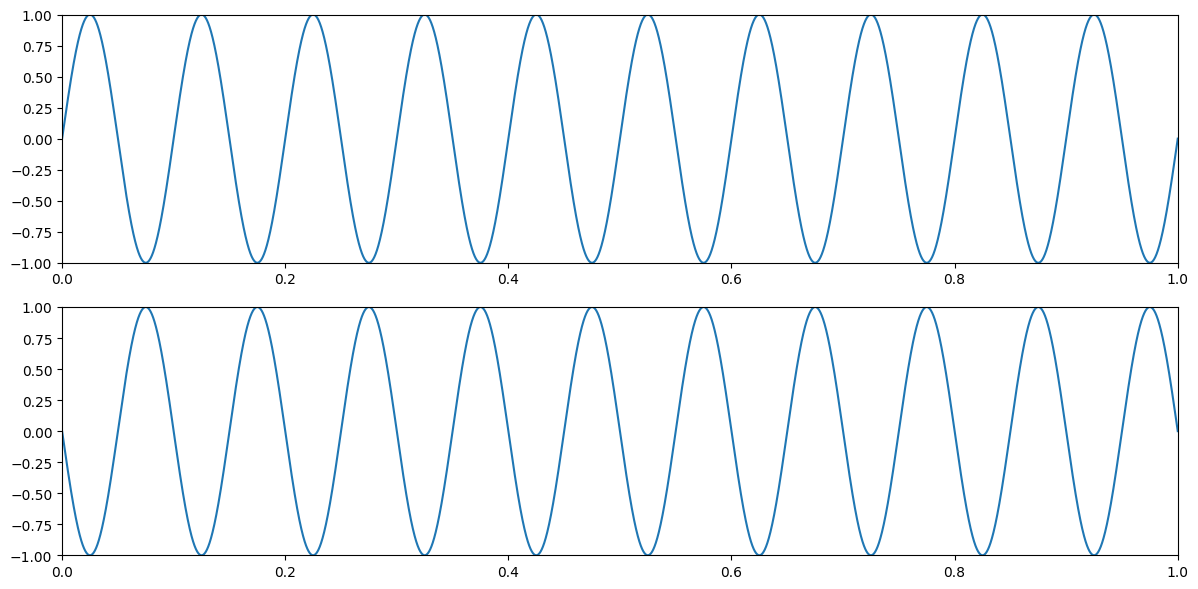

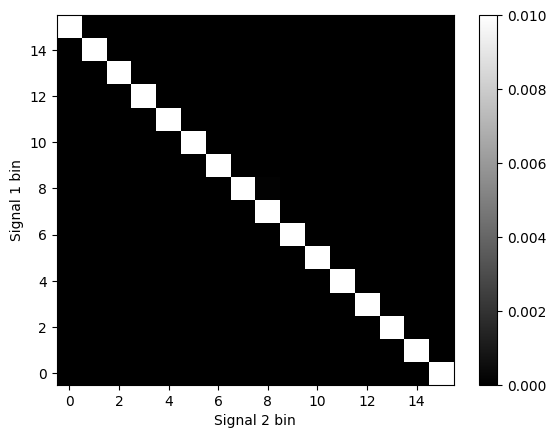

In [6]:
# right panel: random noise
signal1 = np.random.rand(len(signal1)) * 2 - 1
signal2 = np.random.rand(len(signal1)) * 2 - 1

# center panel: one pure sine wave and one sine wave plus random noise
# Uncomment the following lines to use these signals instead
signal1 = np.sin(2 * np.pi * 10 * time)
signal2 = signal1 + np.random.randn(len(signal1)) / 2

# left panel: one pure sine wave and its inverse
# Uncomment the following lines to use these signals instead
signal1 = np.sin(2 * np.pi * 10 * time)
signal2 = -signal1

# determine the optimal number of bins for each variable
n = len(signal1)
maxmin_range = np.max(signal1) - np.min(signal1)
fd_bins1 = np.ceil(maxmin_range / (2.0 * iqr(signal1) * n ** (-1/3)))  # Freedman-Diaconis

n = len(signal2)
maxmin_range = np.max(signal2) - np.min(signal2)
fd_bins2 = np.ceil(maxmin_range / (2.0 * iqr(signal2) * n ** (-1/3)))  # Freedman-Diaconis

# and use the average...
fd_bins = int(np.ceil((fd_bins1 + fd_bins2) / 2))

# bin data (using np.histogram)
edges1 = np.linspace(min(signal1), max(signal1), fd_bins + 1)
edges2 = np.linspace(min(signal2), max(signal2), fd_bins + 1)
nPerBin1, _ = np.histogram(signal1, edges1)
nPerBin2, _ = np.histogram(signal2, edges2)

# Get the bin indices for each value in signal1 and signal2
bin_indices1 = np.digitize(signal1, edges1) - 1  # -1 to convert to 0-based indexing
bin_indices2 = np.digitize(signal2, edges2) - 1  # -1 to convert to 0-based indexing

# compute joint frequency table
jointprobs = np.zeros((fd_bins, fd_bins))
for i1 in range(fd_bins):
    for i2 in range(fd_bins):
        jointprobs[i1, i2] = np.sum((bin_indices1 == i1) & (bin_indices2 == i2))
jointprobs /= np.sum(jointprobs)

# Plot the signals
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(time, signal1)
plt.xlim([time[0], time[-1]])
plt.ylim([-1, 1])
plt.subplot(212)
plt.plot(time, signal2)
plt.xlim([time[0], time[-1]])
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

# Plot the joint probability matrix
plt.figure()
plt.imshow(jointprobs, cmap='gray', aspect='auto')
plt.colorbar()
plt.xlabel('Signal 2 bin')
plt.ylabel('Signal 1 bin')
plt.clim(0, 0.01)
plt.gca().invert_yaxis()
plt.show()

### Figure 29.7

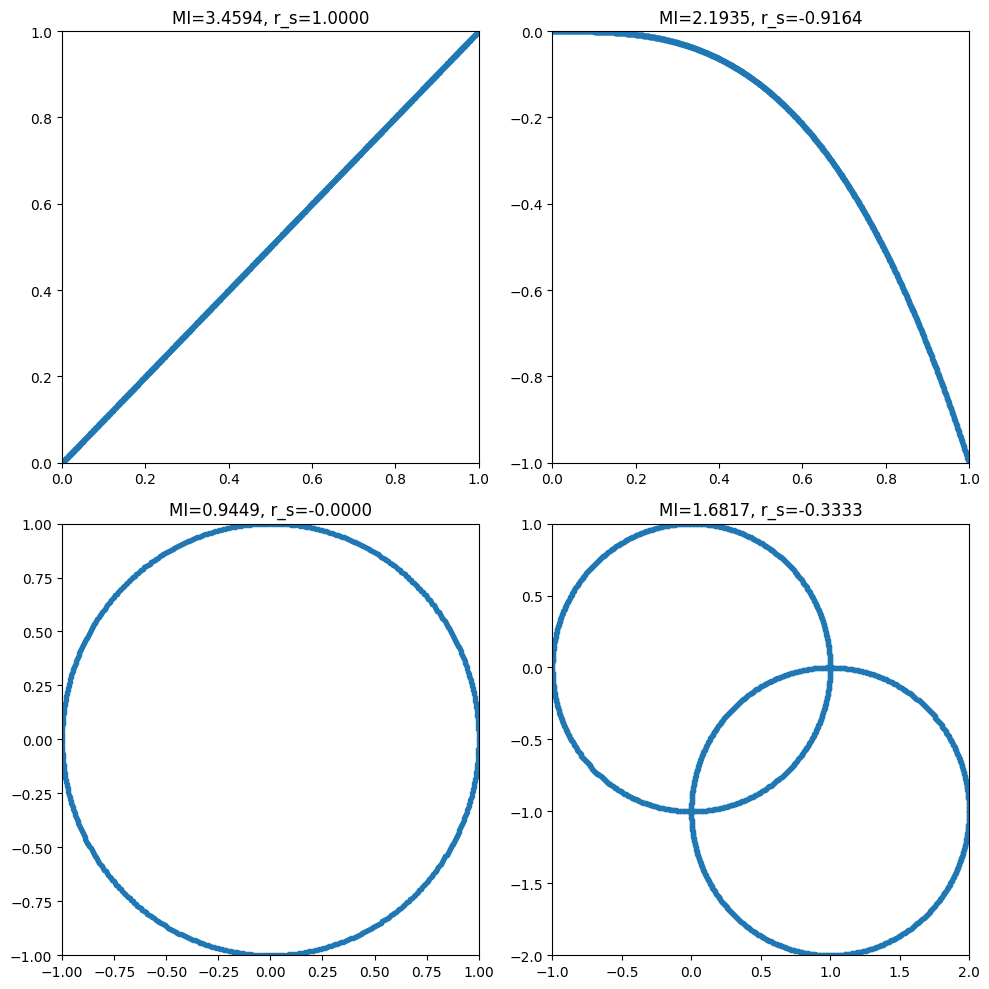

In [7]:
# Plot the signals and their mutual information
plt.figure(figsize=(10, 10))

plt.subplot(221)
x = np.arange(0, 1.001, 0.001)
y = x
plt.plot(x, y, '.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'MI={mutualinformationx(x, y)[0]:.4f}, r_s={np.corrcoef(x, y)[0, 1]:.4f}')

plt.subplot(222)
x = np.arange(0, 1.001, 0.001)
y = -x**3
plt.plot(x, y, '.')
plt.xlim([0, 1])
plt.ylim([-1, 0])
plt.title(f'MI={mutualinformationx(x, y)[0]:.4f}, r_s={np.corrcoef(x, y)[0, 1]:.4f}')

plt.subplot(223)
x = np.cos(np.arange(0, 2 * np.pi, 0.01))
y = np.sin(np.arange(0, 2 * np.pi, 0.01))
plt.plot(x, y, '.')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title(f'MI={mutualinformationx(x, y)[0]:.4f}, r_s={np.corrcoef(x, y)[0, 1]:.4f}')

plt.subplot(224)
x = np.concatenate([np.cos(np.arange(0, 2 * np.pi, 0.01)), np.cos(np.arange(0, 2 * np.pi, 0.01)) + 1])
y = np.concatenate([np.sin(np.arange(0, 2 * np.pi, 0.01)), np.sin(np.arange(0, 2 * np.pi, 0.01)) - 1])
plt.plot(x, y, '.')
plt.xlim([-1, 2])
plt.ylim([-2, 1])
plt.title(f'MI={mutualinformationx(x, y)[0]:.4f}, r_s={np.corrcoef(x, y)[0, 1]:.4f}')

plt.tight_layout()
plt.show()

### Figure 29.8

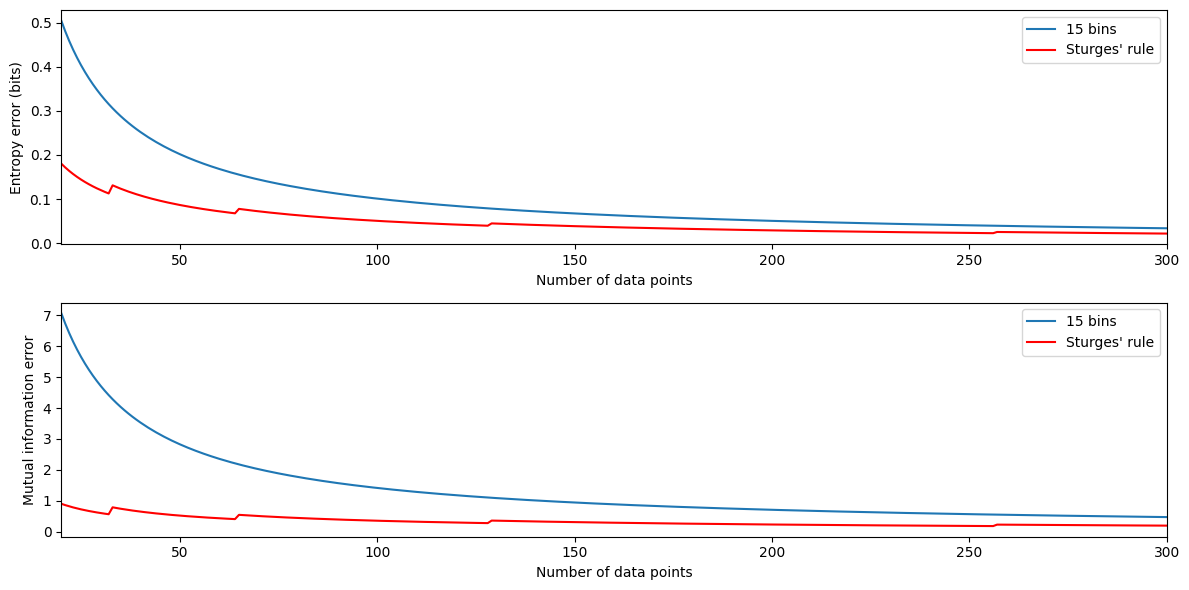

In [8]:
# Define error estimation functions
def entropy_error(b, n):
    return (b - 1) / (2.0 * n * np.log(2))

def mutinfo_error(b, n):
    return (b - 1)**2 / (2.0 * n * np.log(2))

# Define range of data points and fixed number of bins
n = np.arange(20, 301)
nfixed = 15

# Calculate errors
entropy_errors_fixed = entropy_error(nfixed, n)
entropy_errors_sturges = entropy_error(np.ceil(1 + np.log2(n)), n)
mutinfo_errors_fixed = mutinfo_error(nfixed, n)
mutinfo_errors_sturges = mutinfo_error(np.ceil(1 + np.log2(n)), n)

# Plot entropy error
plt.figure(figsize=(12, 6))

plt.subplot(211)
plt.plot(n, entropy_errors_fixed, label=f'{nfixed} bins')
plt.plot(n, entropy_errors_sturges, 'r', label="Sturges' rule")
plt.legend()
plt.xlabel('Number of data points')
plt.ylabel('Entropy error (bits)')
plt.xlim([n[0], n[-1]])

# Plot mutual information error
plt.subplot(212)
plt.plot(n, mutinfo_errors_fixed, label=f'{nfixed} bins')
plt.plot(n, mutinfo_errors_sturges, 'r', label="Sturges' rule")
plt.legend()
plt.xlabel('Number of data points')
plt.ylabel('Mutual information error')
plt.xlim([n[0], n[-1]])

plt.tight_layout()
plt.show()

### Figure 29.9

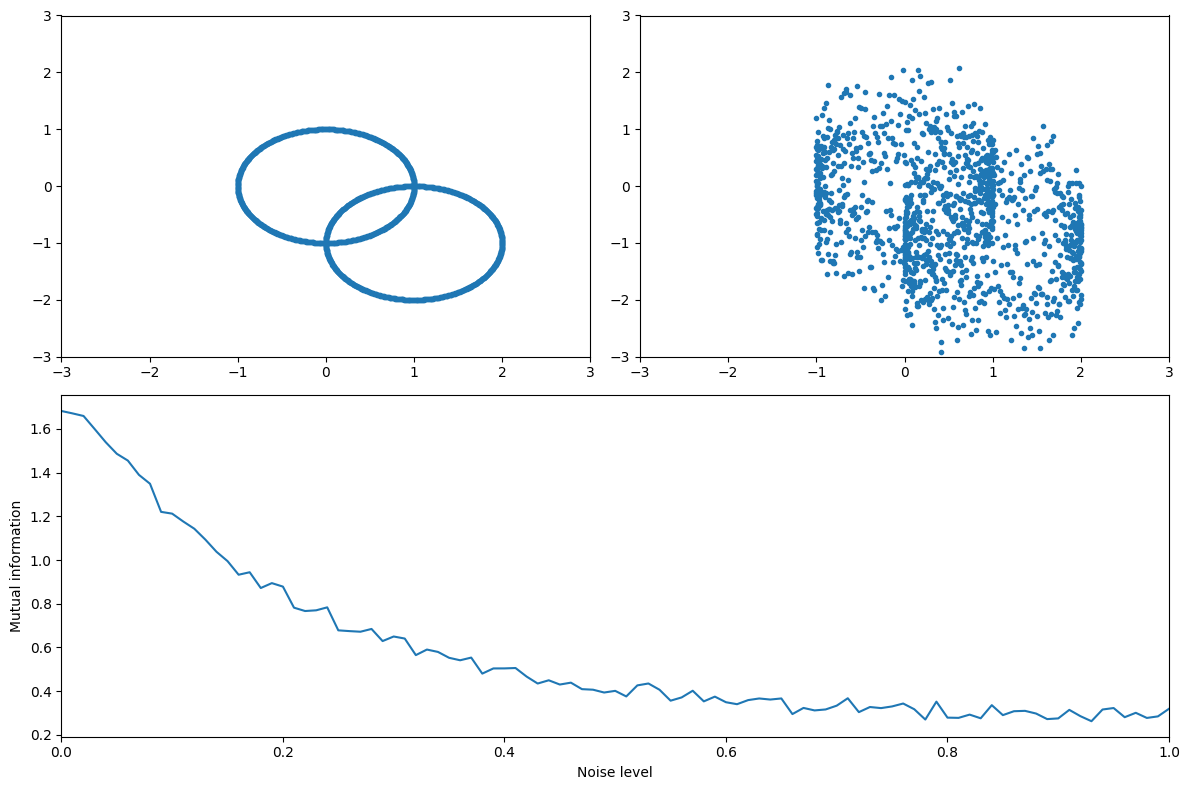

In [9]:
# Define the signals
x = np.concatenate([np.cos(np.arange(0, 2 * np.pi, 0.01)), np.cos(np.arange(0, 2 * np.pi, 0.01)) + 1])
y = np.concatenate([np.sin(np.arange(0, 2 * np.pi, 0.01)), np.sin(np.arange(0, 2 * np.pi, 0.01)) - 1])

# Define noise levels and initialize mutual information array
noiselevels = np.arange(0, 1.01, 0.01)
mi = np.zeros(len(noiselevels))

# Calculate mutual information for different levels of noise
for ni in range(len(noiselevels)):
    noisy_y = y + np.random.randn(len(y)) * noiselevels[ni]
    mi[ni] = mutualinformationx(x, noisy_y)[0]

# Plot the original signal without noise
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(x, y, '.')
plt.axis([-3, 3, -3, 3])

# Plot the mutual information as a function of noise level
plt.subplot(212)
plt.plot(noiselevels, mi)
plt.xlim([noiselevels[0], noiselevels[-1]])
plt.xlabel('Noise level')
plt.ylabel('Mutual information')

# Plot the signal with an intermediate level of noise
plt.subplot(222)
mid_noise_idx = round(len(noiselevels) / 2)
plt.plot(x, y + np.random.randn(len(y)) * noiselevels[mid_noise_idx], '.')
plt.axis([-3, 3, -3, 3])

plt.tight_layout()
plt.show()

### Figure 29.9d

(takes a while to run)

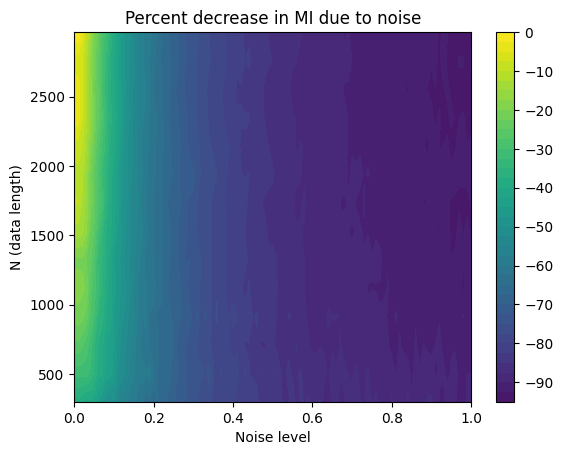

In [10]:
# Define the range of data lengths and noise levels
nrange = np.arange(300, 3000, 205)
noiselevels = np.arange(0, 1.01, 0.01)

# Initialize the mutual information matrix and bin number array
mi = np.zeros((len(nrange), len(noiselevels)))
b = np.zeros(len(nrange)).astype(int)  # number of histogram bins

# Loop over different data lengths
for ni, n in enumerate(nrange):
    # Define time and signals
    t = np.linspace(0, 2 * np.pi, n)
    x = np.concatenate([np.cos(t), np.cos(t) + 1])
    y = np.concatenate([np.sin(t), np.sin(t) - 1])
    
    # Loop over different noise levels
    for noi, noise in enumerate(noiselevels):
        if noi == 0:  # keep number of bins constant across noise levels within each number of points
            mi[ni, noi], _, b[ni] = mutualinformationx(x, y + np.random.randn(len(y)) * noise)
        else:
            mi[ni, noi] = mutualinformationx(x, y + np.random.randn(len(y)) * noise, fd_bins=b[ni])[0]

# Convert to percent change from best-case scenario (no noise, large N)
mip = 100 * (mi - mi[-1, 0]) / mi[-1, 0]

# Plot the percent decrease in MI due to noise
plt.figure()
plt.contourf(noiselevels, nrange, mip, 40, cmap='viridis', vmin=-100, vmax=0)
plt.colorbar()
plt.xlabel('Noise level')
plt.ylabel('N (data length)')
plt.title('Percent decrease in MI due to noise')
plt.show()

### Figure 29.10

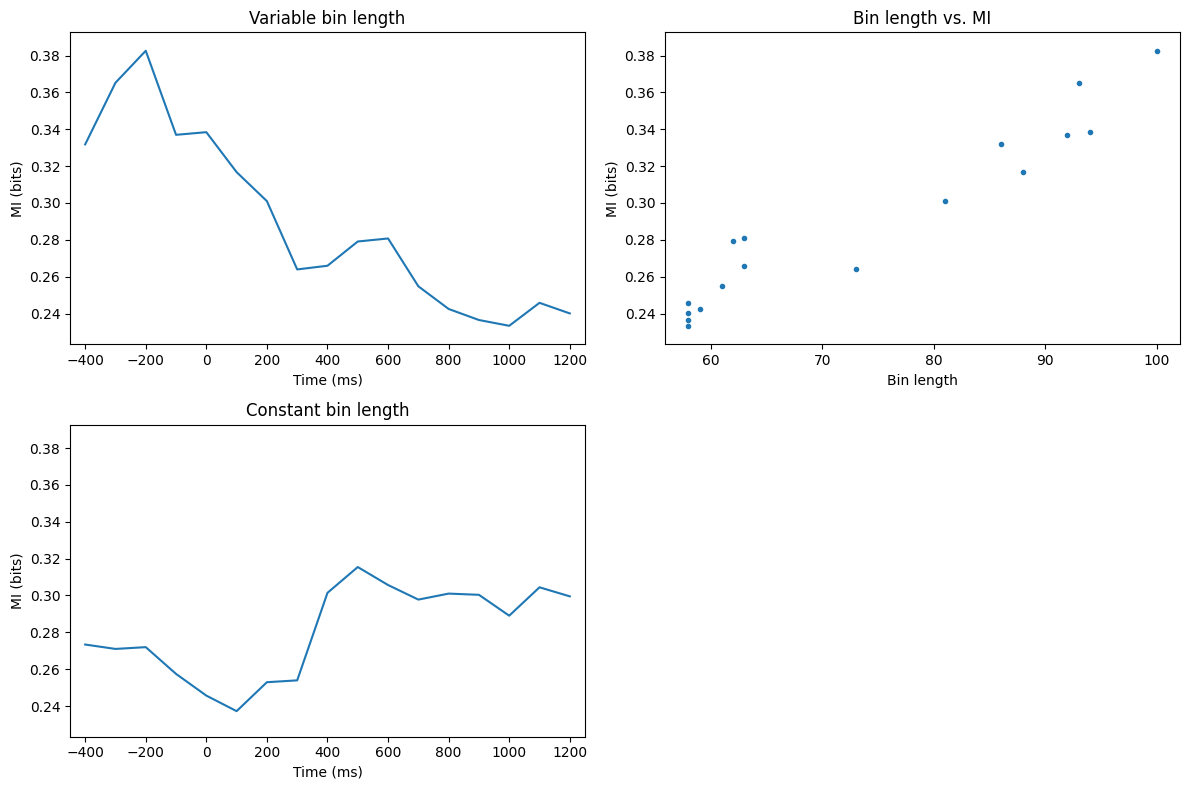

In [11]:
# Define electrodes for mutual information analysis and other parameters
electrodes4mi = ['Fz', 'O1']
timewindow = 400  # in ms
times2save = np.arange(-400, 1201, 100)

# Convert ms to indices
timewindowidx = round(timewindow / (1000 / EEG['srate'][0][0]) / 2)
times2saveidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save]

# Find the indices of the selected electrodes
electrodesidx = [EEG['chanlocs'][0]['labels']==electrodes4mi[0], EEG['chanlocs'][0]['labels']==electrodes4mi[1]]

# Initialize outputs
entropy = np.zeros((3, len(times2save)))
mi = np.zeros((2, len(times2save)))
nbins = np.zeros(len(times2save))

# Calculate mutual information over time
for timei, tidx in enumerate(times2saveidx):
    datax = EEG['data'][electrodesidx[0], tidx - timewindowidx:tidx + timewindowidx + 1, :].flatten('F')
    datay = EEG['data'][electrodesidx[1], tidx - timewindowidx:tidx + timewindowidx + 1, :].flatten('F')

    # Determine the number of bins for each variable using the Freedman-Diaconis rule
    bins_x = int(np.ceil((np.max(datax) - np.min(datax)) / (2 * iqr(datax) / len(datax) ** (1 / 3))))
    bins_y = int(np.ceil((np.max(datay) - np.min(datay)) / (2 * iqr(datay) / len(datay) ** (1 / 3))))
    nbins[timei] = max(bins_x, bins_y)  # Use the larger number of bins

    # Calculate mutual information with variable bin length
    mi[0, timei] = mutualinformationx(datax, datay, fd_bins=int(nbins[timei]))[0]

    # Calculate mutual information with fixed bin length (e.g., 70)
    mi[1, timei] = mutualinformationx(datax, datay, fd_bins=70)[0]

# Plot the mutual information over time
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(times2save, mi[0, :])
plt.xlabel('Time (ms)')
plt.ylabel('MI (bits)')
plt.title('Variable bin length')
plt.xlim([times2save[0] - 50, times2save[-1] + 50])
plt.ylim([np.min(mi) - 0.01, np.max(mi) + 0.01])

plt.subplot(222)
plt.plot(nbins, mi[0, :], '.')
plt.xlabel('Bin length')
plt.ylabel('MI (bits)')
plt.title('Bin length vs. MI')
plt.ylim([np.min(mi) - 0.01, np.max(mi) + 0.01])

plt.subplot(223)
plt.plot(times2save, mi[1, :])
plt.xlabel('Time (ms)')
plt.ylabel('MI (bits)')
plt.title('Constant bin length')
plt.xlim([times2save[0] - 50, times2save[-1] + 50])
plt.ylim([np.min(mi) - 0.01, np.max(mi) + 0.01])

plt.tight_layout()
plt.show()

### Figure 29.11

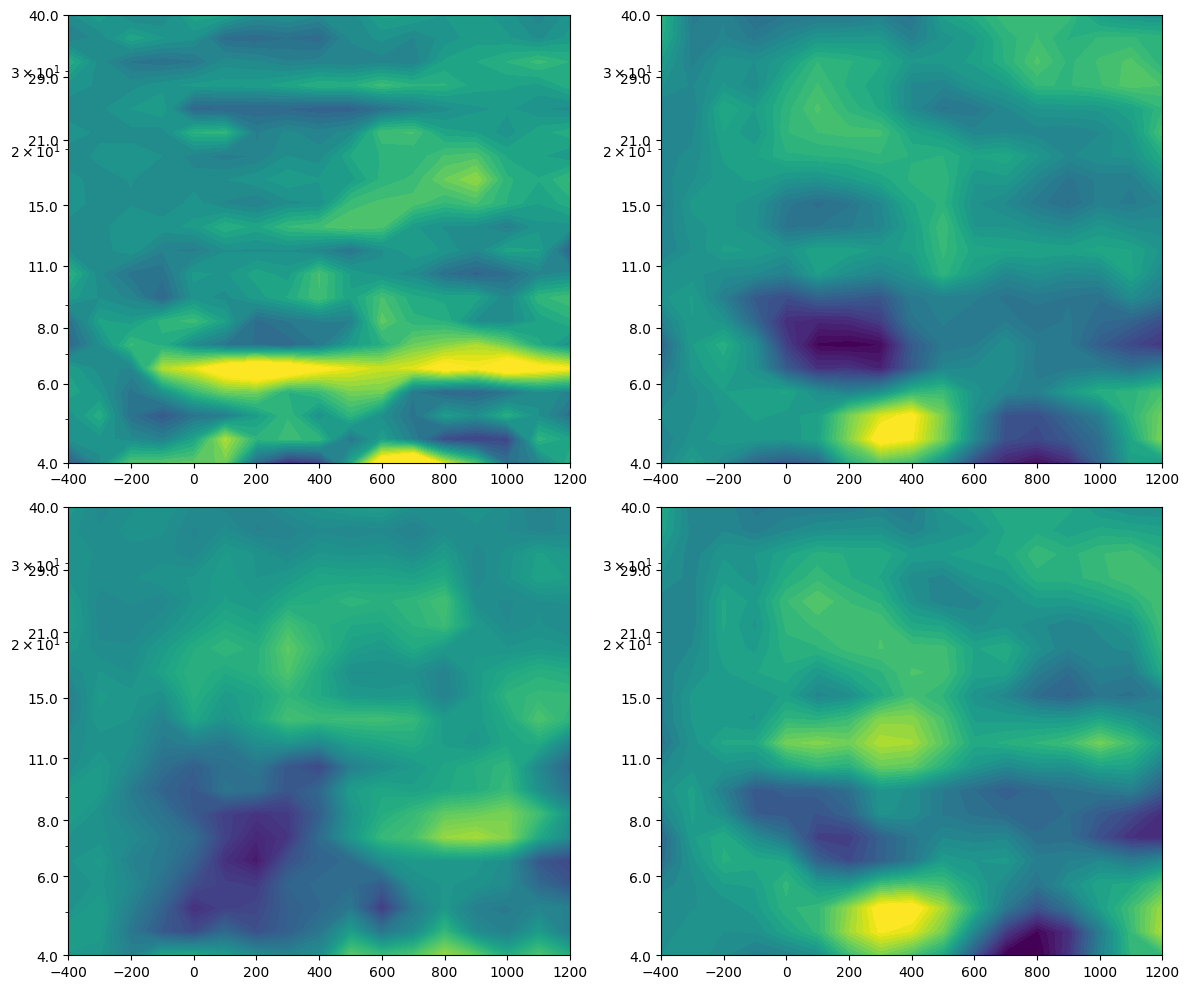

In [40]:
# Define frequency range and baseline time window
frex = np.logspace(np.log10(4), np.log10(40), 20)
baselinetime = [-500, -200]

# Convert baseline time window to indices
baseidx = [np.argmin(np.abs(times2save - t)) for t in baselinetime]

# Specify convolution parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
half_wavelet = (len(time) - 1) // 2
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1

# FFT of data for both electrodes
fft_EEG1 = fft(EEG['data'][electrodesidx[0], :, :].flatten('F'), n_convolution)
fft_EEG2 = fft(EEG['data'][electrodesidx[1], :, :].flatten('F'), n_convolution)

# Initialize outputs
mi = np.zeros((2, len(frex), len(times2save)))
ispc = np.zeros((len(frex), len(times2save)))
powc = np.zeros((len(frex), len(times2save)))

# Loop over frequencies
for fi, f in enumerate(frex):
    # Create wavelet and get its FFT
    wavelet = np.exp(2 * 1j * np.pi * f * time) * np.exp(-time ** 2 / (2 * (4 / (2 * np.pi * f)) ** 2))
    fft_wavelet = fft(wavelet, n_convolution)
    
    # Convolution for each electrode
    convres = ifft(fft_wavelet * fft_EEG1, n_convolution)
    analytic1 = np.reshape(convres[half_wavelet:-half_wavelet], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    convres = ifft(fft_wavelet * fft_EEG2, n_convolution)
    analytic2 = np.reshape(convres[half_wavelet:-half_wavelet], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Loop over time points
    for ti, tidx in enumerate(times2saveidx):
        # Get analytic signal in the time window around the time point
        datax = analytic1[tidx - timewindowidx:tidx + timewindowidx + 1, :]
        datay = analytic2[tidx - timewindowidx:tidx + timewindowidx + 1, :]
        
        # Compute mutual information for power and phase
        mi[0, fi, ti] = mutualinformationx(np.log10(np.abs(datax)**2), np.log10(np.abs(datay)**2), fd_bins=50)[0]
        mi[1, fi, ti] = mutualinformationx(np.angle(datax), np.angle(datay), fd_bins=20)[0]
        
        # Compute inter-site phase clustering (ISPC)
        ispc[fi, ti] = np.mean(np.abs(np.mean(np.exp(1j * (np.angle(datay) - np.angle(datax))), axis=1)), axis=0)
        
        # Compute power correlation (Spearman's rank correlation)
        dataxr = rankdata(np.abs(datax), axis=0)
        datayr = rankdata(np.abs(datay), axis=0)
        n = timewindowidx*2+1
        powc[fi, ti] = np.mean(1 - 6 * np.sum((dataxr - datayr) ** 2, axis=0) / (n * (n ** 2 - 1)))

# Plot the results
plt.figure(figsize=(12, 10))

for i in range(2):
    # Plot mutual information
    plt.subplot(2, 2, i+1)
    plt.contourf(times2save, frex, mi[i, :, :] - np.mean(mi[i, :, baseidx[0]:baseidx[1]+1], axis=1)[..., np.newaxis], 40, cmap='viridis', vmin=-0.075, vmax=0.075)
    plt.yscale('log')
    plt.yticks(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)))
    plt.gca().set_yticklabels(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)))

# Plot power correlation
plt.subplot(2, 2, 3)
plt.contourf(times2save, frex, powc - np.mean(powc[:, baseidx[0]:baseidx[1]+1], axis=1)[..., np.newaxis], 40, cmap='viridis', vmin=-0.2, vmax=0.2)
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)))
plt.gca().set_yticklabels(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)))

# Plot inter-site phase clustering
plt.subplot(2, 2, 4)
plt.contourf(times2save, frex, ispc - np.mean(ispc[:, baseidx[0]:baseidx[1]+1], axis=1)[..., np.newaxis], 40, cmap='viridis', vmin=-0.1, vmax=0.1)
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)))
plt.gca().set_yticklabels(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 8)))

plt.tight_layout()
plt.show()

### Figure 29.12

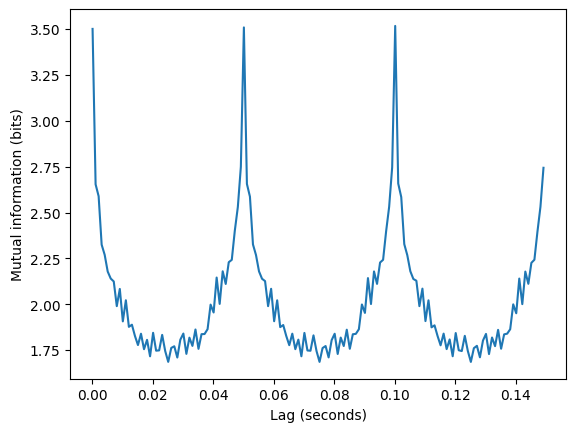

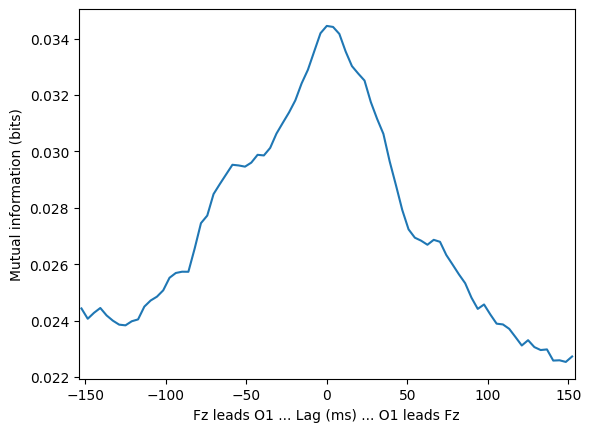

In [51]:
# Define the signals
time = np.arange(0, 1.0001, 0.0001)
signal1 = np.sin(2 * np.pi * 10 * time)
signal2 = -signal1

# Define lags
lagz = np.arange(1, 1501, 10)
milags = np.zeros(len(lagz))

# Calculate mutual information for different lags
for li, lag in enumerate(lagz):
    # Compute mutual information
    milags[li] = mutualinformationx(signal1, np.roll(signal2, lag), fd_bins=15)[0]

# Plot mutual information as a function of lag
plt.figure()
plt.plot(lagz / (1 / np.mean(np.diff(time))), milags)
plt.xlabel('Lag (seconds)')
plt.ylabel('Mutual information (bits)')
plt.show()

# Now on real data (6 Hz power MI from figure 11)

# Create wavelet and get its FFT
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
fft_wavelet = fft(np.exp(2 * 1j * np.pi * frex[4] * time) * np.exp(-time ** 2 / (2 * (4 / (2 * np.pi * frex[4])) ** 2)), n_convolution)

# Convolution for each electrode with wavelet
convres = ifft(fft_wavelet * fft_EEG1, n_convolution)
pow1 = np.log10(np.abs(np.reshape(convres[half_wavelet:-half_wavelet], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')) ** 2)

convres = ifft(fft_wavelet * fft_EEG2, n_convolution)
pow2 = np.log10(np.abs(np.reshape(convres[half_wavelet:-half_wavelet], (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')) ** 2)

# Define lags for real data
onecycle = round(1000 / frex[4])
onecycleidx = int(onecycle / (1000 / EEG['srate'][0][0]))

lagz = np.arange(-onecycleidx, onecycleidx + 1)
milags = np.zeros(len(lagz))

# Calculate mutual information for different lags on real data
for li, lag in enumerate(lagz):
    if lag < 0:
        milags[li] = mutualinformationx(pow1[:lag, :], pow2[-lag:, :], fd_bins=30)[0]
    elif lag == 0:
        milags[li] = mutualinformationx(pow1, pow2, fd_bins=30)[0]
    else:
        milags[li] = mutualinformationx(pow1[lag:, :], pow2[:-lag, :], fd_bins=30)[0]

# Plot mutual information as a function of lag for real data
plt.figure()
plt.plot(1000 * lagz / EEG['srate'][0][0], milags)
plt.xlabel(f"{electrodes4mi[0]} leads {electrodes4mi[1]} ... Lag (ms) ... {electrodes4mi[1]} leads {electrodes4mi[0]}")
plt.ylabel('Mutual information (bits)')
plt.xlim([-onecycle, onecycle])
plt.show()